In [1]:
# nitanshalon, nitanshalon@wustl.edu, Shalon, Nitan
# k.sherman, k.sherman@wustl.edu, Sherman, Kenneth
# choij, jdc6@wustl.edu, Choi, Jason
# jdecavel-bueff, d.jonathan@wustl.edu, Decavel-Bueff, Jonathan

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
import random
import matplotlib.pyplot as plt

In [3]:
def get_train_test(path, split_perc=0.25, label_col="Horizontal_Distance_To_Fire_Points", id_col="ID", 
                   categorical="Soil_Type", normalize=True, train=True, split=True):
    data = pd.read_csv(path) # read in data
    data = data.drop([id_col], axis=1) # drop the id column in the training so that it's not a feature
    soil_type_transform = onehot_encode(data[categorical]) # one-hot encode the only categorical feature in the data
    if train: # only extract labels if we're on a training set
        data_labels = data[[label_col]].to_numpy() # extract labels
        drop_cols = [categorical, label_col] # columns to drop if on train set
    else:
        data_labels = np.zeros((1,)) # create empty labels... just cuz'
        drop_cols = [categorical] # columns to drop if on test set
    data = data.drop(drop_cols, axis=1) # drop the categorical and labels so we can normalize the data
    
    if normalize:
        data = normalize_data(data)
        
    data = append_to_data(data, soil_type_transform) # return the augmented df with the one-hot encoding for soil type
    
    if train and split:
        return split_data(data.values, data_labels, split_perc) # if training (validating) then split the data
    elif not split:
        return data.values, data_labels # if training but getting the model to test, then don't split so we can use all the data to train
    else:
        return data.values # if testing then don't split the data and just return features

In [4]:
def normalize_data(data):
    scaler = preprocessing.MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(data.to_numpy()))

In [5]:
def onehot_encode(data, id_pos_1=1, id_pos_2=2):
    soil_types = set() # set of unique soil types based on first two ints of the soil_type column
    for ele in data:
        soil_types.add(str(ele)[:2])
    soil_types_arr = np.array(list(soil_types))
    print("data len %s ; number of soiltypes %s" % (len(data), len(soil_types)))
    onehots = np.zeros(shape=(len(data), len(soil_types))) # initialize the one-hot encoding for the soil type as a matrix of zeroes
    for data_ind, val in enumerate(data): # iterate through the data
        soil_type_ind = np.argwhere(soil_types_arr == str(val)[:2]) # match the data soiltype to the soil index in the feature array
        onehots[data_ind, soil_type_ind] = 1 # change the position of the corresponding soil type to a 1 for the specific data point 
    return onehots

In [6]:
def append_to_data(data, onehots):
    for soiltype in range(onehots.shape[1]):
        soiltype_colname = "soiltype=%s" % (soiltype)
        data[soiltype_colname] = onehots[:, soiltype]
    return data

In [7]:
def split_data(x, y, split_perc):
    n = x.shape[0]
    num_test = int(split_perc * n)
    test_inds = list(np.random.choice(np.arange(n), num_test))
    train_inds = np.random.choice(np.arange(n), num_test)
    test_inds = np.setdiff1d(np.arange(n), test_inds)
    train_x = x[train_inds, :]
    train_y = np.reshape(y[train_inds], (len(train_inds),))
    test_x = x[test_inds, :]
    test_y = np.reshape(y[test_inds], (len(test_inds),))
    
    return train_x, train_y, test_x, test_y

In [8]:
def get_loss(y_hat, y):
    return (np.linalg.norm(np.array(y_hat) - np.array(y)) ** 2) / len(y)

In [9]:
def ridge(train_x, train_y, test_x,
                alpha=1.0, get_model=False, normalize=True):
    # define model
    model = Ridge(alpha=alpha, normalize=normalize)
    model.fit(train_x, train_y)
    if get_model:
        return model
    y_hat = model.predict(test_x)
    return y_hat

In [10]:
def huber(train_x, train_y, test_x, test_y,
                   epsilon=1.35, max_iter=1e3, normalize=True):
        # define model
    model = HuberRegressor(epsilon=epsilon, max_iter=max_iter)
    model.fit(train_x, train_y)
    y_hat = model.predict(test_x)
    return y_hat

In [11]:
train_x, train_y, test_x, test_y = get_train_test("/kaggle/input/wustl-cse517a-sp21-milestone1/train.csv")
train_x_orig, train_y_orig, test_x_orig, test_y_orig = get_train_test("/kaggle/input/wustl-cse517a-sp21-milestone1/train.csv", normalize=False)

data len 7438 ; number of soiltypes 6
data len 7438 ; number of soiltypes 6


In [12]:
normalized_losses = []
reg_constants = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]
for alpha in reg_constants:
    normalized_losses.append(get_loss(ridge(train_x, train_y.ravel(), test_x, alpha=alpha), test_y.ravel()))

min validation loss on normalized data 1168209 with regularization constant 0.0001


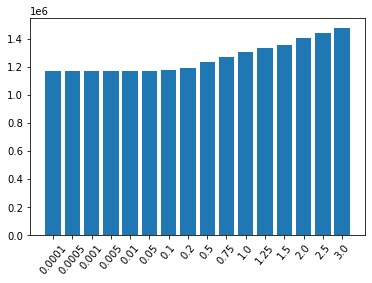

In [13]:
print("min validation loss on normalized data %.0f with regularization constant %s" % (np.min(normalized_losses), reg_constants[np.argmin(normalized_losses)]))
fig = plt.figure()
plt.bar([str(r) for r in reg_constants], normalized_losses)
plt.xticks(rotation = 50)
plt.show()

In [14]:
losses = []
for alpha in reg_constants:
    losses.append(get_loss(ridge(train_x_orig, train_y_orig.ravel(), test_x_orig, alpha=alpha), test_y_orig.ravel()))

min validation loss on unnormalized data 1185568 with regularization constant 0.001


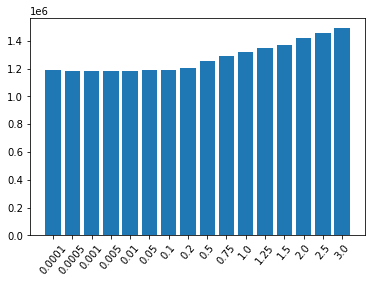

In [15]:
print("min validation loss on unnormalized data %.0f with regularization constant %s" % (np.min(losses), reg_constants[np.argmin(losses)]))
fig = plt.figure()
plt.bar([str(r) for r in reg_constants], losses)
plt.xticks(rotation = 50)
plt.show()

In [16]:
# normilization doesn't really seem to help... but we'll go with it
# now we're training our final model to submit label predictions
train_x, train_y = get_train_test("/kaggle/input/wustl-cse517a-sp21-milestone1/train.csv", split=False)
test_x = get_train_test("/kaggle/input/wustl-cse517a-sp21-milestone1/test.csv", train=False)
test_x = np.delete(test_x, test_x.shape[1] - 1, 1) # delete the 7th soil type column, not sure why the training set has 6 soiltypes and the test set has 7

data len 7438 ; number of soiltypes 6
data len 11157 ; number of soiltypes 7


In [17]:
test_model = ridge(train_x, train_y, None, get_model=True)

In [18]:
test_preds = test_model.predict(test_x).ravel()
test_ids = pd.read_csv("/kaggle/input/wustl-cse517a-sp21-milestone1/test.csv")["ID"]
test_submission = pd.DataFrame({
    "ID" : test_ids,
    "Horizontal_Distance_To_Fire_Points" : test_preds
})

In [19]:
test_submission.to_csv('submission.csv', index=False)